<a href="https://colab.research.google.com/github/maulshreegarg/maulshreegarg/blob/main/SAM_CTScan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-oxtu8mqu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-oxtu8mqu
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [9]:
!pip install -q roboflow supervision
# Used for operations on images.

In [10]:
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'
# Pretrained weights of segment anything

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
! mv '/content/sam_vit_h_4b8939.pth' '/content/drive/MyDrive/Preethi_Projects/Segment Anything'
# '/content/drive/MyDrive/SAM/'

mv: cannot move '/content/sam_vit_h_4b8939.pth' to '/content/drive/MyDrive/Preethi_Projects/Segment Anything': No such file or directory


In [15]:
CHECKPOINT_PATH = '/content/sam_vit_h_4b8939.pth'

In [16]:
import torch
from segment_anything import sam_model_registry

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

To generate masks automatically, use the **SamAutomaticMaskGenerator**. This utility generates a list of dictionaries describing individual segmentations. Each dict in the result list has the following format:

1. segmentation - [np.ndarray] - the mask with (W, H) shape, and bool type, where W and H are the width and height of the original image, respectively
2. area - [int] - the area of the mask in pixels
3. bbox - [List[int]] - the boundary box detection in xywh format
4. predicted_iou - [float] - the model's own prediction for the quality of the mask
5. point_coords - [List[List[float]]] - the sampled input point that generated this mask
6. stability_score - [float] - an additional measure of mask quality
crop_box - List[int] - the crop of the image used to generate this mask in xywh format




In [19]:
# IMAGE_PATH = '/content/drive/MyDrive/SAM/images/Landscape-Color.jpg'
# IMAGE_PATH = '/content/drive/MyDrive/SAM/images/istockphoto-1332336417-612x612.jpg'
#/content/drive/MyDrive/SAM/images/Landscape-Color.jpg
IMAGE_PATH = "/content/sample_data/abdo-ct-norm.jpg"

In [20]:
import cv2
from segment_anything import SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(sam)

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
result = mask_generator.generate(image_rgb)

In [21]:
len(result)

54

In [22]:
import supervision as sv
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(result)
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

In [23]:
annotated_image.shape

(445, 458, 3)

In [24]:
import cv2
from google.colab.patches import cv2_imshow

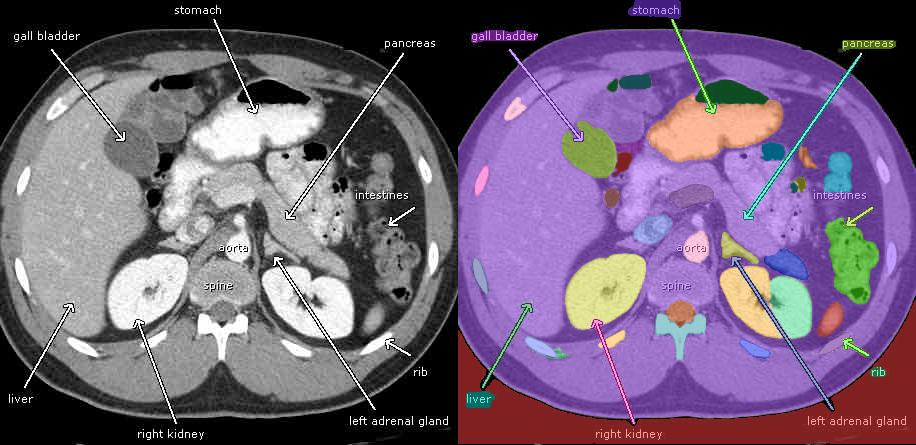

In [25]:
import cv2
from google.colab.patches import cv2_imshow

# Check if image is loaded properly
if annotated_image is None:
    print('Error: Could not load image')
else:
    # Resize image
    new_width, new_height = 500, 300
    resized_image = cv2.resize(annotated_image, (new_width, new_height))


    # Combine original and resized images horizontally
    combined_image = cv2.hconcat([image_bgr, annotated_image])

    # Display combined image
    cv2_imshow(combined_image)



In [ ]:
import supervision as sv
masks = [mask['segmentation'] for mask in sorted(result , key = lambda x : x['area'] , reverse = True)]

In [ ]:
len(masks)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Calculate grid size
num_images = 9
num_cols = 3
num_rows = int(np.ceil(num_images / num_cols))

# Plot the image grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 16))
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(masks[i])
    ax.set_axis_off()
plt.show()

# Generate Segmentation Mask with Bounding Box

Now that you know how to generate a mask for all objects in an image, let’s see how you can use a bounding box to focus SAM on a specific portion of your image.


To extract masks related to specific areas of an image, import the SamPredictor and pass your bounding box through the mask predictor’s predict method. Note that the mask predictor has a different output format than the automated mask generator. The bounding box format for the SAM model should be in the form of [x_min, y_min, x_max, y_max] np.array.

In [ ]:
import os

IMAGE_PATH1 = '/content/drive/MyDrive/Preethi_Projects/Segment Anything/dog.jpg'

In [ ]:
import base64

def encode_image(filepath):

  with open(filepath , 'rb') as f:
    image_bytes = f.read()
  encoded = str(base64.b64encode(image_bytes) , 'utf-8')
  return "data:image/jpg;base64," +encoded

In [ ]:
import cv2
from segment_anything import SamPredictor
import numpy as np

mask_predictor = SamPredictor(sam)

image_bgr = cv2.imread(IMAGE_PATH1)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
mask_predictor.set_image(image_rgb)

box = np.array([427,149,568,406])
masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

In [ ]:
masks.shape

In [ ]:
detections2 = sv.Detections(xyxy =sv.mask_to_xyxy(masks=masks),
                            mask=masks)

In [ ]:
annotated_image2 = mask_annotator.annotate(image_bgr, detections2)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Check if image is loaded properly
if annotated_image is None:
    print('Error: Could not load image')
else:
    # Resize image
    new_width, new_height = 500, 300
    resized_image = cv2.resize(annotated_image2, (new_width, new_height))


    # Combine original and resized images horizontally
    combined_image = cv2.hconcat([image_bgr, annotated_image2])

    # Display combined image
    cv2_imshow(combined_image)



Finally what if we use a generic object detector and then train it for custom use case lets say people detection and then pass the image to object detector first and then to SAM it will aid in annotating all person image masks at once!!